### Special project !

Welcome, we are Lavinia and Simon and our goal is to help Batrick Pruel improving his poker skills. 

To do so, our goals are the following:

- Detect the number and color of chips on the table
- Detect and output the symbol and digit of the cards for each player
- Detect and output the symbol and digit of the cards set by the dealer

Let's make sure we do a good job to allow Batrick to go all in. 


In [1]:
#!pipenv install treys==0.1.4
#!pip install treys==0.1.4
#!pipenv install termcolor
#!pipenv install pandas
#!pipenv install jupyter-black

In [2]:
# Auto-format code

#import black
#import jupyter_black

#jupyter_black.load(
#    lab=True,
#    line_length=150,
#    target_version=black.TargetVersion.PY310,
#)

In [3]:
# Imports for project
import PIL.Image
import numpy as np
from typing import Union
from glob import glob
import pandas as pd
from skimage import exposure
from treys import Card
from termcolor import colored
from utils import eval_listof_games, debug_listof_games, save_results, load_results
import matplotlib.pyplot as plt


import sys
import math
import cv2 as cv
import itertools
import os

# [IAPR][iapr]: Project


**Group ID:** 05

**Author 1 (sciper):** Lavinia Schlyter (284566)
**Author 2 (sciper):** Simon Gilgien (253797)  

**Release date:** 29.04.2022


## Important notes

The assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Introduction

An anonymous card player that we will name Bartick Pruel is willing to improve his poker skills. To do so, he asked our lab to design a tool that will automatically detect the hands of the players around the table. 

---

## 1. Data

To achieve your task, you will be given images that look like this (without the overlay)

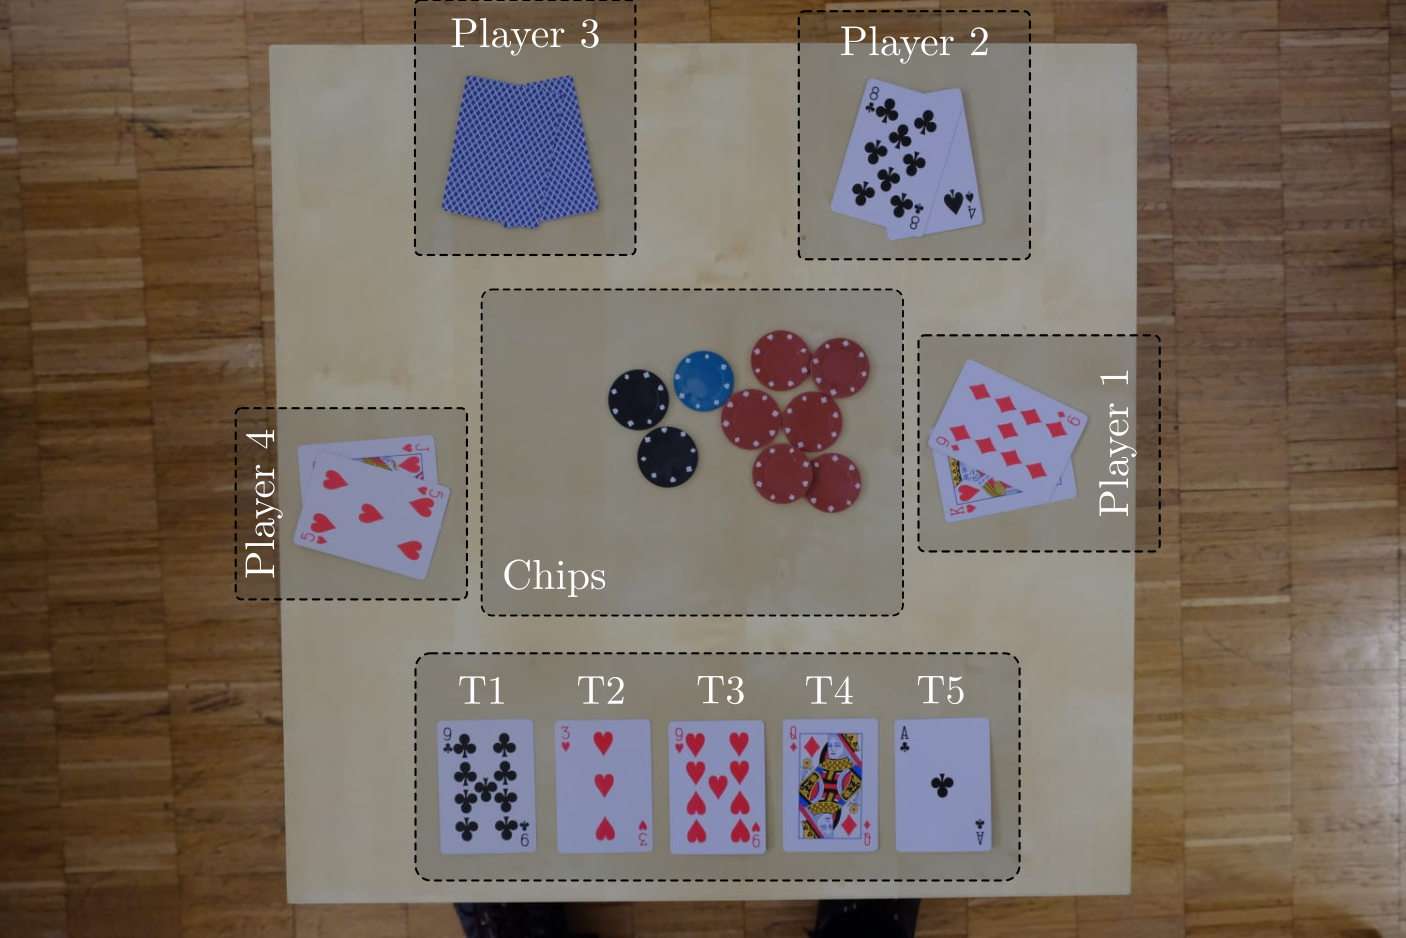


### 1.1. Table layout

The table is divided into 3 main parts:
* **Table cards (T1-T5)**: These cards are shared by every player. They are defined as the flop (T1-T3), the turn (T4) and the river (T5). The table cards are *always* visible.
* **Player cards (P11-P42)**: The cards played by each player (4 pairs). Each player *always* has 2 cards in hand. When a player is not playing, you can see the back of the cards (ex: player 3 here).
* **Chips**: The chips at the center of the table are named the pot.

### 1.2. Cards & Chips

The cards deck are composed of 52 cards split into 4 different colors: (D)imanond, (H)eart, (S)pade, (C)lub. Each color is composed of 13 different cards: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, (J)ack, (Q)ueen, (K)ing.

Th chips can be of 5 different colors: (r)ed, (g)reen, (b)lue, blac(k) or (w)hite.


### 1.3 Structure

You can download the data for the project here: [download data](https://drive.google.com/file/d/1d7rOe88kEK1CEaLvYgNZkxrtKImLVC9X/view)

```
data 
│
└─── image_setup
│    │    back_cards.jpg      # Back of the cards (either blue or red)
│    │    chips.jpg           # Set of chips used (red, green, blue, black, white)
│    │    kings.jpg           # Kings from the 4 colors (diamond, heart, spade, club)
│    │    spades_suits.jpg    # All cards of spades (1 - 10, Jack, Queen, King)
│    │    table.jpg           # Empty table
│    └─── ultimate_test.jpg   # If it works on that image, you would probably end up with a good score
│
└─── train
│    │    train_00.jpg        # Train image 00
│    │    ...
│    │    train_27.jpg        # Train image 27
│    └─── train_labels.csv    # Ground truth of the train set
│
└─── test
     │    test_00.jpg         # Test image 00 (day of the exam only)
     │    ...
     └─── test_xx             # Test image xx (day of the exam only)
```


---

## 2. Tasks


Your task is to predict the following parameters for a set of images.

* **T1** (str): String code of the first card of the flop (far left) 
* **T2** (str): String code of the second card of the flop
* **T3** (str): String code of the third card of the flop
* **T4** (str): String code of the turn
* **T5** (str): String code of the river


* **P11** (str or int): String code of player 1 card 1. Should be 0 if player 1 is not Playing.
* **P12** (str or int): String code of player 1 card 2. Should be 0 if player 1 is not Playing.
* **P21** (str or int): String code of player 2 card 1. Should be 0 if player 2 is not Playing.
* **P22** (str or int): String code of player 2 card 2. Should be 0 if player 2 is not Playing.
* **P31** (str or int): String code of player 3 card 1. Should be 0 if player 3 is not Playing.
* **P32** (str or int): String code of player 3 card 2. Should be 0 if player 3 is not Playing.
* **P41** (str or int): String code of player 4 card 1. Should be 0 if player 4 is not Playing.
* **P42** (str or int): String code of player 4 card 2. Should be 0 if player 5 is not Playing.


* **CR** (int): Number of (r)ed chips in the pot
* **CG** (int): Number of (g)reen chips in the pot
* **CB** (int): Number of (b)lue chips in the pot
* **CK** (int): Number of blac(k) chips in the pot
* **CW** (int): Number of (w)hite chips in the pot


The output is saved using the function **save_results** as presented below.

---
## 3. Evaluation

**Before the exam**
   - Create a zipped folder named **groupid_xx.zip** that you upload on moodle (xx being your group number).
   - Include a **runnable** code (Jupyter Notebook and external files) and your presentation in the zip folder.
   
**The day of the exam**
   - You will be given a **new folder** with few images, but **no ground truth** (csv file).
   - We will ask you to run your pipeline in **real time** and to send us your prediction of the task you obtain with the provided function **save_results**. 
   - On our side, we will compute the performance of your classification algorithm. 
   - To evaluate your method, we will use the **evaluate_game** function presented below. To understand how the provided functions work, please read the documentation of the functions in **utils.py**.
   - **Please make sure your function returns the proper data format to avoid points penalty on the day of the exam**. 
---


## 4. Your code

### Detect table

Idea:
- Convert image to grayscale 
- Blurr the image
- Detect edges with Canny filter
- Line hough transform to find the lines on the 4 sides of the table
- Extract the corners of the table 
- Compute and transform the image in order to make the table straight + crop

In [4]:
def open_image(file):
    return cv.cvtColor(cv.imread(file), cv.COLOR_BGR2RGB)

In [5]:
table = open_image("../project_data/image_setup/table.jpg")

In [6]:
def basic_processing(image_array, kernel_size=201):
    try:
        image_array_copy = image_array.copy()
        # Convert to gray
        image_gray = cv.cvtColor(image_array_copy, cv.COLOR_RGB2GRAY)

        # Gaussian blur
        image_gray_blur = cv.GaussianBlur(image_gray, (kernel_size, kernel_size), 0)
        return image_gray_blur
    except:
        return None


def canny_filter(image_array, low_thresh=10, high_thresh=100, aperature_size=5, plot_verbose=False):
    edges = cv.Canny(image_array, low_thresh, high_thresh, apertureSize=aperature_size)

    if plot_verbose:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(edges)

    return edges


def hough_transform(image_array, edges, rho=7, theta=np.pi / 90, threshold=1500, minLineLength=2000, maxLineGap=150, plot_verbose=False):

    linesP = cv.HoughLinesP(image=edges, rho=rho, theta=theta, threshold=threshold, minLineLength=minLineLength, maxLineGap=maxLineGap)
    image_copy = image_array.copy()

    # Draw lines for plotting
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv.line(image_copy, (l[0], l[1]), (l[2], l[3]), (255, 0, 0), 3, cv.LINE_AA)

    if plot_verbose:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(image_copy)
    return linesP

In [7]:
def extract_corners_square(linesP):
    try:
        # Given the Hough lines, find the coordinates of eacch corner using prior knowledge on location

        linesP = np.reshape(linesP, (-1, 2))
        x_top_left = np.min(linesP[(linesP[:, 0] < 1500) & (linesP[:, 1] < 1000)][:, 0])
        y_top_left = np.min(linesP[(linesP[:, 0] < 1500) & (linesP[:, 1] < 1000)][:, 1])

        x_bot_left = x_top_left
        y_bot_left = np.max(linesP[(linesP[:, 0] < 1500) & (linesP[:, 1] > 3000)][:, 1])

        x_top_right = np.max(linesP[(linesP[:, 0] > 4000) & (linesP[:, 1] < 1000)][:, 0])
        y_top_right = np.min(linesP[(linesP[:, 0] > 4000) & (linesP[:, 1] < 1000)][:, 1])

        x_bot_right = x_top_right
        y_bot_right = np.max(linesP[(linesP[:, 0] > 4000) & (linesP[:, 1] > 3000)][:, 1])

        return np.float32([[x_top_left, y_top_left], [x_top_right, y_top_right], [x_bot_left, y_bot_left], [x_bot_right, y_bot_right]])
    except:
        return None

In [8]:
def perspective_transform(image_array, initial_corners, plot_verbose=False):
    """

    Parameters
    ----------
    image_array: Input image
    initial_corners: Coordinates of each corner of the image
    plot_verbose: Plotting boolean

    Returns
    -------
    image_perspective: Input image that is redressed to deal with rotated tables
    """
    trans_corners = np.float32([[0, 0], [3500, 0], [0, 3500], [3500, 3500]])
    M_trans = cv.getPerspectiveTransform(initial_corners, trans_corners)
    image_perspective = cv.warpPerspective(image_array, M_trans, (3500, 3500))

    if plot_verbose:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(image_perspective)

    return image_perspective

In [9]:
def crop_reframe_image(image_array):
    """

    Parameters
    ----------
    image_array: input image

    Returns
    -------
    image_reframed: input image that is cropped and redressed, in this case the table

    """
    pre_process = basic_processing(image_array)
    canny_edges = canny_filter(pre_process)
    lines_hough = hough_transform(image_array, canny_edges)
    initial_corners = extract_corners_square(lines_hough)
    # Verify if valid image
    try:
        if initial_corners == None:
            return None

    except:
        image_reframed = perspective_transform(image_array, initial_corners)
        return image_reframed

Save the cropped version of training images to speed up development

In [10]:
train_images_cropped = []

In [11]:
force_crop = False
train_images = glob("../project_data/train/*.jpg")
directory = "../project_data/train_crop/"
if not os.path.exists(directory):
    os.makedirs(directory)
for image_file in train_images:
    path = directory + "train_crop_" + image_file.split("_")[-1]
    if force_crop or not os.path.exists(path):
        image_cropped = crop_reframe_image(open_image(image_file))
        cv.imwrite(path, cv.cvtColor(image_cropped, cv.COLOR_RGB2BGR))
        train_images_cropped.append(image_cropped)

In [12]:
# For cutting bottom cards

train_images_crop = glob("../project_data/train_crop/*.jpg")

### Algo 1: Bottom cards

Idea:
- Find edges of cards, these are found by changing the colorspace to grayscale, blurring the image with a Gaussian filter to remove excessive noise and using a canny filter
- Rescale and redress cards: Using the contours found thanks to the edges, we find the estimated height, width, center coordinates of the cards as well as the rotation. These allow us to isolate and reproject the cards for them to be straight and enable easier identification
- For the cards which were not well identified, aka, no rectangle contour was found, they are cropped grossly, thresholded after enhancing the contrast between fore and background for better isolation and the process is re-iterated. 


[The follwowing steps are explained further down]
- Isolate number and symbol 
- Define card color
- Black and white for symbols with Fourrier 

In [13]:
def isolate_bottom_cards(image, plot_verbose=False):
    """

    Parameters
    ----------
    image : Image of cropped table
    plot_verbose

    Returns
    -------
    CARDS : Dictionary with each card as well as its center coordinates, height, width and rotation angle
    (h,w) : Height and width of initial image
    cropped_image_bottom : Image with the bottom cards cropped


    """
    # Threshold set for positions, in order to detect card order
    threshold_card1 = 500
    threshold_card2 = 1000
    threshold_card3 = 1500
    threshold_card4 = 2000
    threshold_card5 = 2500

    # Crop the bottom part of the image
    cropped_image_bottom = image[2600:3400, 500:3000]

    # Extract height and width
    (h, w) = cropped_image_bottom.shape[:2]

    # Dictionarry for storing cards ((center_x, center_y), (height, width), angle)
    CARDS = {}

    # Function to convert to grayscale + Gaussian blurring
    pre = basic_processing(cropped_image_bottom, kernel_size=15)

    # Detection of edges
    pre_canny_edge = canny_filter(pre, low_thresh=120, high_thresh=200)

    # Find only the external contours
    contours, _ = cv.findContours(pre_canny_edge.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    img_copy = np.copy(cropped_image_bottom)

    # Loop through contours to find best matching one with rectangle (card) of given size
    for cnt in contours:

        rect = cv.minAreaRect(cnt)
        # Center(x,y), (w,h), angle)

        # Check width and heigth to filter as well as angle to avoid any strange rotations (rect[2])
        if (rect[1][0] > 300) & (rect[1][0] < 600) & (rect[1][1] > 300) & ((rect[2] > 70) | (rect[2] < 20)):

            # Located card in order from left to right
            if 0 <= rect[0][0] <= threshold_card1:
                CARDS[0] = rect
            elif threshold_card1 < rect[0][0] <= threshold_card2:
                CARDS[1] = rect
            elif threshold_card2 < rect[0][0] <= threshold_card3:
                CARDS[2] = rect
            elif threshold_card3 < rect[0][0] <= threshold_card4:
                CARDS[3] = rect
            elif threshold_card4 < rect[0][0] <= threshold_card5:
                CARDS[4] = rect
            box = cv.boxPoints(rect)
            box = np.int0(box)
            cv.drawContours(img_copy, [box], 0, (0, 191, 255), 10)

    if plot_verbose:
        plt.imshow(img_copy)

    return CARDS, (h, w), cropped_image_bottom


def crop_bottom_images(CARD, h, w, cropped_image_bottom, second_run=False, plot_verbose=False):

    # Verify whether it is the second time the picture is processed with no success.
    #  AKA, edge detection + contour fail, if so set flag to False for "not processed"
    if (second_run) & (CARD[1][0] == 800):
        croped = cropped_image_bottom
        flag = False
    else:
        # Rotate the image with given angle of card and use card coordinates to crop
        M = cv.getRotationMatrix2D((int(CARD[0][0]), int(CARD[0][1])), find_rotation(CARD), 1.0)
        rotated = cv.warpAffine(cropped_image_bottom, M, (w, h))
        croped = rotated[
            int(CARD[0][1] - max(CARD[1][0], CARD[1][1]) / 2) : int(CARD[0][1] + max(CARD[1][0], CARD[1][1]) / 2),
            int(CARD[0][0] - min(CARD[1][0], CARD[1][1]) / 2) : int(CARD[0][0] + min(CARD[1][0], CARD[1][1]) / 2),
        ]
        flag = True

    if plot_verbose:

        plt.imshow(croped)
        plt.show()

    return croped, flag


def find_rotation(Card_coord):
    # Function that returns in which way must the card be rotated for having it straightened
    if abs(90 - Card_coord[2]) < abs(Card_coord[2]):
        return -(90 - Card_coord[2])
    else:
        return Card_coord[2]


def process_not_found_cards(cards):
    # Approximate card coordinates if cards are not detected by edge detections
    not_found_list = []
    y_center_card = 400
    # Add margin for non found cards
    height_card = 800  # True 550
    width_card = 700  # True 390
    x_center_first_card = 360
    x_jump_center = 470

    # Make a list of non found images for processing later on
    for i in range(5):
        if i not in cards.keys():

            not_found_list.append(i)
            # First card not detected
            if i == 0:
                cards[i] = tuple([(x_center_first_card, y_center_card), (height_card, width_card), 0.0])
            else:
                cards[i] = tuple([(max(cards[i - 1][0][0], cards[i - 1][0][1]) + x_jump_center, y_center_card), (height_card, width_card), 0.0])

    return cards, not_found_list


def post_processing_not_found(CROPED_CARDS, cards, card_number=999, plot_verbose=False):
    # Process the non_found cards again
    img_copy = CROPED_CARDS[card_number].copy()

    # Amplify difference between the white background of the cards and the color of the table
    image_lab = cv.cvtColor(cv.GaussianBlur(img_copy, (9, 9), 0), cv.COLOR_RGB2LAB)

    histogram = exposure.histogram(image_lab[:, :, 0])
    white_level = histogram[1][np.argmax(histogram[0])] - 5

    pre = np.interp(image_lab[:, :, 0], [0, white_level - 1, white_level, 255], [0, 0, 255, 255])

    pre = cv.morphologyEx(pre, cv.MORPH_CLOSE, np.ones((3, 3))).astype(np.uint8)

    if plot_verbose:
        plt.figure()
        plt.imshow(pre)
        plt.show()

    pre_canny_edge = canny_filter(pre, low_thresh=90, high_thresh=250)

    contours, _ = cv.findContours(pre_canny_edge.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    for cnt in contours:

        rect = cv.minAreaRect(cnt)
        if (rect[1][0] > 300) & (rect[1][0] < 600) & (rect[1][1] > 300) & ((rect[2] > 70) | (rect[2] < 20)):

            # Update card rectangle for more precise measures
            cards[card_number] = rect

            box = cv.boxPoints(rect)
            box = np.int0(box)
            cv.drawContours(img_copy, [box], 0, (0, 191, 255), 10)

    if plot_verbose:

        plt.imshow(img_copy)
        plt.show()


def crop_non_found_card(Croped_cards, cards, plot_verbose=False):
    # Function to make a second run into the cropping version

    (h, w) = Croped_cards.shape[:2]
    crop, flag = crop_bottom_images(cards, h, w, Croped_cards, second_run=True, plot_verbose=plot_verbose)  # , flag
    return crop, flag

In [14]:
def equalize_card(image):
    """
    Perform exposure equalization on a card.
    This works in LAB colorspace and the general idea is:
    - Find the luminosity of the white background and match it to a reference value
    - Find the luminosity of the symbols and match it to a reference value
    - Interpolate the luminosity given those two references
    - White balance: if the white background is colored, remove it and interpolate the other values

    Parameters
    ----------
    image: Input image (RGB)

    Returns
    -------
    image_equalized: Input image with normalized exposure (RGB)
    """
    image = cv.cvtColor(image, cv.COLOR_RGB2LAB)

    image_blurred = cv.GaussianBlur(image, (5, 5), 0)

    histogram = exposure.histogram(image_blurred[:, :, 0])

    # Convert to more convenient format
    new_histogram = np.zeros([256])
    for value, i in zip(*histogram):
        new_histogram[i] = value

    histogram = new_histogram

    # Luminosity of the white background
    white_level = np.argmax(histogram)

    limit = int(white_level * 0.75)
    color_level = np.argmax(histogram[:limit])

    # Code was optimized this way but a conceptually better approach would to add + color_level
    minimum_level = np.argmin(histogram[color_level:white_level])

    threshold = min(minimum_level + 30, white_level - 1)

    image[:, :, 0] = np.interp(image[:, :, 0], [0, threshold, white_level, 255], [0, 25, 250, 255])

    # Fix white balance
    for i in range(1, 3):
        histogram = exposure.histogram(image_blurred[:, :, i])

        white_level = histogram[1][np.argmax(histogram[0])]

        image[:, :, i] = np.interp(image[:, :, i], [0, white_level, 255], [50, 128, 205])

    return cv.cvtColor(image, cv.COLOR_LAB2RGB)

In [15]:
def identify_bottom_cards(image, plot_verbose=False, plot_verbose_end=False):
    # Groupped function that returns the cropped cards coordinates

    cards, (h, w), cropped_bottom = isolate_bottom_cards(image, plot_verbose=plot_verbose)
    cards, not_found_list = process_not_found_cards(cards)
    CROPED_CARDS = {}
    flags = {}
    for card_id in range(5):
        CROPED_CARDS[card_id], flags[card_id] = crop_bottom_images(cards[card_id], h, w, cropped_bottom, plot_verbose=plot_verbose)

    # Check for cards that need extra processing

    for card_id in not_found_list:
        # Proceed in finer edge detection
        post_processing_not_found(CROPED_CARDS, cards, card_number=card_id, plot_verbose=plot_verbose)
    for card_id in not_found_list:
        # Update croping for cards not in list
        CROPED_CARDS[card_id], flags[card_id] = crop_non_found_card(CROPED_CARDS[card_id], cards[card_id], plot_verbose=plot_verbose)

    for card_id in CROPED_CARDS:
        CROPED_CARDS[card_id] = equalize_card(CROPED_CARDS[card_id])
    if plot_verbose_end:
        fig, axs = plt.subplots(1, 5, figsize=(10, 8))
        for i in range(5):

            axs[i].imshow(CROPED_CARDS[i])
        plt.show()

    return CROPED_CARDS, flags

In [16]:
TEST_ALGO_BOTTOM = False
if TEST_ALGO_BOTTOM:
    for file_path in train_images_crop:
        im = open_image(file_path)
        # As output you get the image of the card
        bottom_cards_framed, flags = identify_bottom_cards(im, plot_verbose_end=True)

### Recognize digit and symbol
The next step is to extract the digit (or letter) representing the value of the card, and the symbol of the suit. It could be easier to count the symbols on the card, but this method would not work for figures and for cards that are only partially visible.

To identify the suit symbol, we first observe wether the symbol is red or black (this is easy in LAB colorspace). Then we use Fourier descriptors to discriminate the two possible suits. This works well for clean images, but is not very robust to cropped symbols or blurry images.

To identify the digits, we chose to simply correlate the thresholded image of the digit with a reference digit extracted from the calibration image with all spades cards. This works well because the digits are printed and therefore have a very low variation, and the cards are rotated to be vertical so orientation is always (almost) the same. Since the location of the digit may vary depending on how precise the card extraction was, we do the process at different location (like a convolution) and consider the location with the lowest squared error.

Since the image of the corner might be of low quality (e.g. specularity, blurriness), we try both corners of the card if they are both visible and take the results that look most promising.

In [17]:
def find_digit_and_symbol(image):
    """
    Find binary masks of the digit and symbol of the corner of a card.
    Parameters
    ----------
    image: Input image (RGB)

    Returns
    -------
    digit: Binary mask of the identified digit
    symbol: Binary mask of the identified suit symbol
    """

    # Threshold image based on brightness
    image = cv.cvtColor(image, cv.COLOR_RGB2LAB)
    image = (image[:, :, 0] < 200).astype(np.uint8)

    # Remove noise
    image = cv.morphologyEx(image, cv.MORPH_OPEN, np.ones((2, 2)))
    image = cv.morphologyEx(image, cv.MORPH_CLOSE, np.ones((2, 2)))

    # Find connected parts
    n, labels = cv.connectedComponents(image, 8)

    digit = np.zeros(image.shape, np.uint8)
    symbol = np.zeros(image.shape, np.uint8)

    max_coordinates = {}
    symbol_threshold = 60

    for i in range(1, n):
        element = labels == i
        coordinates = np.nonzero(element)

        # Only consider big blobs to reject noise, and blobs that are only on the right of the image,
        # since these are probably parts of the center of the card
        if np.sum(element) > 200 and np.amin(coordinates[1]) < 50:
            # The symbol is the lowest blob in the corner of the card, but its height is not precisely predictable
            max_x = np.amax(coordinates[0])
            max_coordinates[i] = max_x

            if np.amax(coordinates[0]) > symbol_threshold + 20:
                symbol_threshold = max_x - 20

    for i, max_x in max_coordinates.items():
        # Blobs in the top part of the corner are part of the digit
        if max_x < symbol_threshold:
            digit |= labels == i
        # And blobs in the bottom part of the corner are part of the symbol
        else:
            symbol |= labels == i

    return digit, symbol

### Extract card from original table


In this part, we just extract the suit of spades that were given for the setup in order to have them as a reference digit. 

Idea:
- Grayscale + Gaussian blurr 
- Find edges with canny filter 
- Find the contours using the edges and with prior knowledge about the cards such as width and height we can restrict the number of accepted contours.
- Using same algorithm as for the bottom cards we can straighten the card image for easier detection.


In [18]:
suits = open_image("../project_data/image_setup/spades_suits.jpg")

In [19]:
def process_suits_set(im, plot_verbose=False):
    suits_crop = crop_reframe_image(im)
    suits_rect = []
    pre = basic_processing(suits_crop, kernel_size=11)
    pre_canny_edge = canny_filter(pre, low_thresh=220, high_thresh=250)
    img_copy = suits_crop.copy()
    # Find only the external contours
    contours, _ = cv.findContours(pre_canny_edge.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Loop through contours to find best matching one with rectangle (card) of given size
    for cnt in contours:

        rect = cv.minAreaRect(cnt)
        # Center(x,y), (w,h), angle)
        # Check width and heigth to filter as well as angle to avoid any strange rotations (rect[2])
        if (rect[1][0] > 300) & (rect[1][0] < 600) & (rect[1][1] > 300) & (rect[1][1] < 1000) & ((rect[2] > 70) | (rect[2] < 20)):
            box = cv.boxPoints(rect)
            box = np.int0(box)
            cv.drawContours(img_copy, [box], 0, (0, 191, 255), 1)
            suits_rect.append(rect)

    if plot_verbose:
        plt.imshow(img_copy)
    (h, w) = img_copy.shape[:2]
    CROPED_suits = {}
    for suit_id in range(len(suits_rect)):
        CROPED_suits[suit_id + 1], _ = crop_bottom_images(suits_rect[suit_id], h, w, img_copy, plot_verbose=plot_verbose)
    return CROPED_suits

In [20]:
suits_dic = process_suits_set(suits, plot_verbose=False)
# order = 1,2,3,4,5,7,6,8,9, J,Q, 10,K
# Put them in the right order
suits_dic_ordered = suits_dic.copy()
suits_dic_ordered[6] = suits_dic[7]
suits_dic_ordered[7] = suits_dic[6]
suits_dic_ordered[10] = suits_dic[12]
suits_dic_ordered[11] = suits_dic[10]
suits_dic_ordered[12] = suits_dic[11]

#### Extract the digit from the reference suits of spade

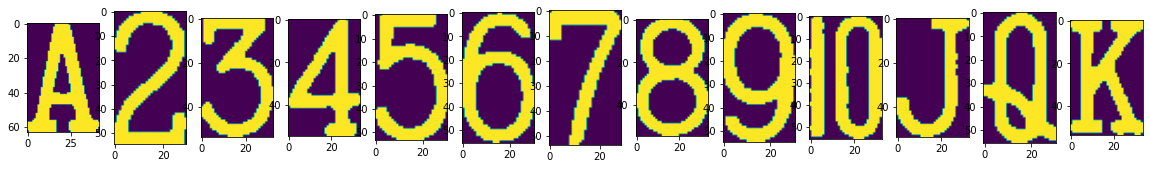

In [21]:
# extract the digit of all reference cards
reference_digits = [find_digit_and_symbol(card[20:150, 20:70])[0] for card in suits_dic_ordered.values()]

plt.figure(figsize=(20, 20))

# Crop the reference digits tightly to allow moving the reference on the corner
for i, digit in enumerate(reference_digits):
    x, y = np.nonzero(digit)
    x_min = np.amin(x)
    x_max = np.amax(x) + 1
    y_min = np.amin(y)
    y_max = np.amax(y) + 1
    reference_digits[i] = digit[x_min:x_max, y_min:y_max]
    # show the digits
    plt.subplot(1, len(reference_digits), i + 1)
    plt.imshow(reference_digits[i])

plt.show()

In [22]:
def interpolate_contour(contour, length):
    """
    Given a contour, interpolate a given number of equidistant points along the contour.
    This function is taken from lab 2.

    Parameters
    ----------
    contour: the contour to follow
    lenght: the number of points to interpolate along the contour

    Returns
    -------
    new_contour: contour composed of the interpolated points
    """
    if len(contour) == 1:
        return [contour[0] for x in range(length)]

    new_contour = []
    for i in range(length):
        index = i * len(contour) / length

        # Fraction of the segment between the last original point and the next one
        k = index - int(index)
        # Index of the last original point before the interpolated point
        index = int(index)

        if index == len(contour) - 1:
            # Linear interpolation
            new_contour.append(contour[-1] * (1 - k) + contour[0] * k)

        else:
            # Linear interpolation
            new_contour.append(contour[index] * (1 - k) + contour[index + 1] * k)

    return new_contour


def detect_symbol(symbol, red_card):
    """
    Given a binary symbol image, identify the suit of the symbol. Also gives a confidence estimate.
    This largely reuses parts of lab 2.

    Parameters
    ----------
    symbol: Input binary image of the symbol
    red_card: Boolean: whether the card is red

    Returns
    -------
    letter: The letter corresponding to the identified suit
    confidence: How confident we are about the prediction. Greater values means more confidence
    """

    # extract contours
    contours, _ = cv.findContours(symbol, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

    if not contours:
        return None, 0

    # take the longest contour
    contour = max(contours, key=lambda c: len(c))

    # convert to complex representation
    contour = [x[0][0] + x[0][1] * 1j for x in contour]

    # interpolate to a fixed lenght
    contour = interpolate_contour(contour, 64)

    # take the fourier transform
    fourier_transform = np.fft.fft(contour)

    # Which terms were taken and the separation line are hand-tuned to have the most separable dataset
    # The absolute value of the distance to the separation line is used as the confidence
    if red_card:
        remainder = abs(fourier_transform[2]) - 2 * abs(fourier_transform[3])
        letter = "D" if remainder < 0 else "H"
    else:
        remainder = 7 * abs(fourier_transform[-1]) - 16 * abs(fourier_transform[1]) - 5194
        letter = "S" if remainder < 0 else "C"

    # force low confidence if the symbol touches the edge of the image, since it might not be complete
    coordinates = np.nonzero(symbol)
    if (
        np.amin(coordinates[0]) == 0
        or np.amax(coordinates[0]) == symbol.shape[0] - 1
        or np.amin(coordinates[1]) == 0
        or np.amax(coordinates[1]) == symbol.shape[1] - 1
    ):
        remainder = 0

    return letter, abs(remainder)


def find_digit(digit):
    """
    Given a binary image of a digit, identify which digit it represents. Also provides a loss value to
    indicate how confident the prediction is.

    This uses the reference digits computed above

    For each digit and each possible position, compute the number of differing pixels
    (normalized by the number of positive pixels in the reference digit and the region of the image).
    The prediction is the digit with the smallest normalized error.

    Parameters
    ----------
    digit: Input binary image of a digit

    Returns
    -------
    symbol: The textual representation of the identified digit or letter
    loss: An indication of how confident the prediction is. Smaller values means more confident predictions.
    """

    # lookup table
    SYMBOLS = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "10", "J", "Q", "K"]

    # Since the digit might be cropped, it is useful to pad the image
    digit = np.pad(digit, (10,))

    # Compute the minimum error across possible locations for each digit
    errors = []
    for reference in reference_digits:
        error_map = cv.matchTemplate(digit, reference, cv.TM_SQDIFF_NORMED)
        errors.append(np.amin(error_map))

    # Select the digit with the smallest minimum error
    index = np.argmin(errors)

    return SYMBOLS[index], errors[index]


def classify_card(image, lower_corner_valid=True):
    """
    Identify which card an image represents. If both corners are valid, the most confident prediction is used,
    so we still get correct prediction even when one of the corner is blurry or under a specularity.

    Parameters
    ----------
    image: Input image of the card (RGB)
    lower_corner_valid: Boolean: is the lower right corner of the card valid (i.e. not under another card)

    Returns
    -------
    digit_char: The textual representation of the identified digit or letter
    symbol_char: The character representing the identified suit
    """

    # Crop the corners
    upper_corner = image[10:200, 10:70]
    corners = [upper_corner]

    if lower_corner_valid:
        # Crop the corner and rotate it by 180°
        lower_corner = image[-11:-201:-1, -11:-71:-1]
        corners.append(lower_corner)

    symbols = []
    red_card = False

    # Default if no digit can be identified
    digit_char = "A"
    digit_loss = math.inf

    for corner in corners:
        digit, symbol = find_digit_and_symbol(corner)

        # If the digit or symbol can't be extracted, try to unblur the image
        if not digit.any() or not symbol.any():
            kernel = -np.ones((5, 5))
            kernel[2, 2] = 25

            corner_sharpened = cv.filter2D(corner, ddepth=-1, kernel=kernel)

            digit, symbol = find_digit_and_symbol(corner_sharpened)

        # Wait until we know for sure which color is the card
        symbols.append(symbol)

        # Use prediction with the lowest loss
        char, loss = find_digit(digit)
        if loss < digit_loss:
            digit_char, digit_loss = char, loss

        # Check whether the symbol is red
        mask = (digit | symbol) == 0
        if np.sum(~mask) > 200:
            corner_lab = cv.cvtColor(upper_corner, cv.COLOR_RGB2LAB)
            masked_image = np.ma.masked_array(corner_lab, np.broadcast_to(np.expand_dims(mask, 2), corner_lab.shape))
            color = masked_image.mean(axis=(0, 1))
            mean_color = corner_lab.mean(axis=(0, 1))

            red_card |= color[1] - mean_color[1] > 6

    # Now we know the final prediction of the card color and we can take the most confident suit
    symbol_char = None
    symbol_confidence = -1
    for symbol in symbols:
        char, confidence = detect_symbol(symbol, red_card)
        if confidence > symbol_confidence:
            symbol_char, symbol_confidence = char, confidence

    # Default if no symbol can be read on both corners
    if not symbol_char:
        symbol_char = "H" if red_card else "S"

    return digit_char, symbol_char

In [23]:
# Visualize results during development

char_to_symbol = {"S": "♠️", "C": "♣️", "D": "♦️", "H": "♥️", None: " "}

if TEST_ALGO_BOTTOM:
    for file_path in train_images_crop:
        im = open_image(file_path)

        plt.figure()
        plt.imshow(im[2500:, 500:3000, :])
        plt.show()
        cards, flags = identify_bottom_cards(im)

        for i, card, flag in zip(range(len(cards)), cards.values(), flags.values()):
            if flag:
                digit, symbol = classify_card(card)

                print(digit, char_to_symbol[symbol], end=" ", sep="")

### Algo 2: Chips

Idea:
- Blurring + Canny edge detection
- Circle Hough transform to find circles with a radius close to that of a chip (find circles with many edge pixels on them)
- The outside of the circles is the table, get its mean color (in LAB colorspace)
- From the circles, construct a mask of regions where multiple chips overlap. The color in these regions might not match the color of the chip below.
- For each chip, get its mean color from a smaller circular region at the center of the chip, ignoring overlapping regions (in LAB colorspace)
- Thresholds on absolute chip color and difference between chip color and table color to discriminate the colors

In [24]:
def chips(image):
    """Given the image of the table, detects and counts the chips of each color.
    Returns a dict with the number of chip for the name of each color"""

    # Crop the center of the image, where the chips are located
    image = image[950:2600, 900:2500]
    w, h = image.shape[:2]

    # Detect the edges with a Canny filter
    edges = canny_filter(basic_processing(image, 25), low_thresh=80, high_thresh=120, aperature_size=5)

    # Find circles with the Hough transform for circles. We know that the radius of the chips is about 122 pixels
    circles = cv.HoughCircles(edges, method=cv.HOUGH_GRADIENT, dp=5, minDist=90, param2=200, minRadius=115, maxRadius=125)

    if circles is None:
        centers = []
    else:
        # We're only interested in the center since we know the radius
        centers = [(int(circle[0]), int(circle[1])) for circle in circles[0]]

    # Build a map of the number of overlapping chips
    chip_count_mask = np.zeros((w, h), dtype=np.uint8)

    for center in centers:
        mask_to_add = np.zeros((w, h), dtype=np.uint8)
        cv.circle(mask_to_add, center, 123, 1, -1)
        chip_count_mask += mask_to_add

    overlap_mask = chip_count_mask <= 1

    # Compute the mean color of the table (region without chips) in LAB colorspace as a reference for the exposure
    table_color = np.ma.masked_array(
        cv.cvtColor(image, cv.COLOR_RGB2LAB), mask=np.broadcast_to(np.expand_dims(chip_count_mask != 0, 2), image.shape)
    ).mean(axis=(0, 1))

    # We use a small circular area around the center of each chip to detect the color.
    RADIUS = 60
    mask = np.zeros((2 * RADIUS + 1, 2 * RADIUS + 1), dtype=float)
    cv.circle(mask, (RADIUS, RADIUS), RADIUS, 1.0, -1)
    mask = mask.astype(bool)

    nb_chips = {code: 0 for code in ("CK", "CR", "CB", "CG", "CW")}

    for y, x in centers:
        # Copy the mask so we can modify it
        center_mask = mask.copy()

        # Region to crop
        x_min = x - RADIUS
        y_min = y - RADIUS
        x_max = x + RADIUS + 1
        y_max = y + RADIUS + 1

        # Boundary conditions
        if x_min < 0:
            center_mask = center_mask[-x_min:, :]
            x_min = 0
        if y_min < 0:
            center_mask = center_mask[:, -y_min:]
            y_min = 0
        if x_max > w:
            center_mask = center_mask[: w - x_max, :]
            x_max = w
        if y_max > h:
            center_mask = center_mask[:, : h - y_max]
            y_max = h

        # Crop the relevant region of the image
        center_image = image[x_min:x_max, y_min:y_max, :]
        # Mask the parts where chips overlap since the chip we observe might be behind
        center_mask &= overlap_mask[x_min:x_max, y_min:y_max]

        center_image = cv.cvtColor(center_image, cv.COLOR_RGB2LAB)

        mean_color = np.ma.masked_array(center_image, mask=np.broadcast_to(np.expand_dims(~center_mask, 2), center_image.shape)).mean(axis=(0, 1))

        color_diff = mean_color - table_color

        if mean_color[1] > 150:
            nb_chips["CR"] += 1
        elif color_diff[0] > -10:
            nb_chips["CW"] += 1
        elif color_diff[1] < -15:
            nb_chips["CG"] += 1
        elif mean_color[2] < 100 or (color_diff[2] < -30 and mean_color[0] > 55):
            nb_chips["CB"] += 1
        else:
            nb_chips["CK"] += 1

    return nb_chips

In [25]:
# Test on training images during development
test_chips = False

if test_chips:
    train_images_crop = glob("../project_data/train_crop/*.jpg")
    for image_file in train_images_crop:
        im = open_image(image_file)

        for color, nb in chips(im).items():
            print(nb, color)

        plt.figure()
        plt.imshow(im[950:2600, 900:2500])
        plt.show()

## Algo 3: Players

Idea:

- For each image, crop the area for each player
- Rotate the the image in order to have them straight up (keeping the original size)
- Figure out whether the cards are face down using the hough line transform to identify the number of lines in the images and set the threshold (note that the behind of the cards are either red or blue but all have the same patterned lines)
- Use color histogram in order to set a threshold to better identify the edges of the cards. The threshold is made to be adapative in order to take into account various color changes and lack or increase in exposure. The threshold is set differently based on where the maximum is located. 
- In order to make it easier for the canny filter, the external contours are found and their tickness is enhanced by several pixels. This allows Canny to only find the outside part of the card (making it easier for the Hough transform)

For the cards that need to be processed:
- Find the coordinates of the card corners using Hough lines 
- Prior knowledge of the cards (such as width and height) enables us to find the center of the cards: In this case, we don't have the contour rectangles, because of the overlapping of the cards. Rather we use the hough lines and coordinates of two out of the 4 corners to extrapolate the location of the card. 
- For each approximated center of the two overlapping cards, rotate the image in order for them to be straight up
- Equalize color of the cards for easier symbol and number detection 
- Classify the cards using the same algorithm as for the table cards



In [26]:
def rotate_players(im, angle=0, plot_verbose=False):

    (h, w) = im.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # We rotate the image by the correct angle and keep scale = 1
    M = cv.getRotationMatrix2D((cX, cY), angle, 1.0)

    # Keep same image sizes
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # Perform rotation
    rotated = cv.warpAffine(im, M, (nW, nH))
    if plot_verbose:
        plt.imshow(rotated)
        plt.show()

    return rotated


def preprocess_players(im, plot_verbose=False):

    # Player 1 position
    cropped_image_p1 = im[1100:2200, 2500:-50]
    # Rotate by correct angle
    rotated_p1 = rotate_players(cropped_image_p1, angle=-90, plot_verbose=plot_verbose)

    # Player 2 position
    cropped_image_p2 = im[0:900, 2000:3000]
    # Rotate by correct angle
    rotated_p2 = rotate_players(cropped_image_p2, angle=180, plot_verbose=plot_verbose)

    # Player 3 position
    cropped_image_p3 = im[0:900, 500:1500]
    # Rotate by correct angle
    rotated_p3 = rotate_players(cropped_image_p3, angle=180, plot_verbose=plot_verbose)

    # Player 4 position
    cropped_image_p4 = im[1300:2300, 0:900]
    # Rotate by correct angle
    rotated_p4 = rotate_players(cropped_image_p4, angle=90, plot_verbose=plot_verbose)

    return [rotated_p1, rotated_p2, rotated_p3, rotated_p4]


def identify_face_down_card(img):
    # Blur the image largery to remove irrelevant noise
    im_blurr = cv.GaussianBlur(img, (31, 31), 0)
    edges = canny_filter(im_blurr.copy(), plot_verbose=False)
    lines = hough_transform(img, edges, rho=2, theta=np.pi / 90, threshold=10, minLineLength=4, maxLineGap=10, plot_verbose=False)

    try:

        if len(lines) > 5000:
            # The card is facing down

            return True
    except:
        return False

In [27]:
def player_edges(player_im, plot_verbose=False):
    im = player_im.copy()

    # Find if players are faced_down
    bool_face_down = identify_face_down_card(im)

    threshold = 0
    hist = cv.calcHist([im], [2], None, [256], [0, 256])

    hist = hist[:, 0]
    thresh_max = np.argmax(hist[1:-10])

    # addition of margin to escape peak
    # In the case where the luminosity is low, the peak will be located along the middle and we can add extra margin due to broader peak

    if thresh_max < 100:
        threshold = thresh_max + 30
    else:
        threshold = thresh_max + 20

    img_copy = im.copy()

    edges_contours = None

    # If card is face down, no need to process
    if not bool_face_down:
        # Gaussian blur
        kernel_size = 9
        im = cv.GaussianBlur(im, (kernel_size, kernel_size), 0)

        ret, gray = cv.threshold(im[:, :, 2], threshold, 255, 0)

        contours, _ = cv.findContours(gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        edges_contours = np.zeros_like(img_copy[:, :, 0])
        edges_contours = cv.drawContours(edges_contours, contours, -1, (255), 4)

        if plot_verbose:
            plt.plot(hist, color="b")
            plt.vlines(x=threshold, ymin=0, ymax=20000)
            plt.show()

            plt.imshow(gray, cmap="gray")
            plt.show()
            plt.imshow(edges_contours)
            plt.show()
    return edges_contours, img_copy, bool_face_down


def rotate_player_cards(x_center, y_center, angle, card_dy, card_dx, img_copy, plot_verbose=False):
    # Dictionarry for storing cards ((center_x, center_y), (height, width), angle)
    CARD = {}
    CARD[0] = (x_center, y_center)
    CARD[1] = (card_dy, card_dx)
    CARD[2] = math.degrees(angle)
    # Extract height and width
    (h, w) = img_copy.shape[:2]
    M = cv.getRotationMatrix2D((int(CARD[0][0]), int(CARD[0][1])), CARD[2], 1.0)
    rotated = cv.warpAffine(img_copy, M, (w, h))
    croped = rotated[
        int(CARD[0][1] - max(CARD[1][0], CARD[1][1]) / 2) : int(CARD[0][1] + max(CARD[1][0], CARD[1][1]) / 2),
        int(CARD[0][0] - min(CARD[1][0], CARD[1][1]) / 2) : int(CARD[0][0] + min(CARD[1][0], CARD[1][1]) / 2),
    ]

    if plot_verbose:
        plt.imshow(croped)
        plt.show()

    return croped


def isolate_player(edges, img_copy, plot_verbose=False):

    lines_hough = hough_transform(
        img_copy, edges, rho=2, theta=np.pi / 180, threshold=100, minLineLength=400, maxLineGap=100, plot_verbose=plot_verbose
    )
    try:

        # Coordinates of the corners
        linesP = np.reshape(lines_hough, (-1, 2))
        # Top left card
        x_top_left = np.min(linesP[(linesP[:, 0] < 500) & (linesP[:, 1] < 500)][:, 0])
        y_top_left = np.min(linesP[(linesP[:, 0] < 500) & (linesP[:, 1] < 500)][:, 1])

        # Bottom left card
        x_bot_left = np.min(linesP[(linesP[:, 0] < 500) & (linesP[:, 1] > 500)][:, 0])
        y_bot_left = np.max(linesP[(linesP[:, 0] < 500) & (linesP[:, 1] > 500)][:, 1])

        # Top right card
        x_top_right = np.max(linesP[(linesP[:, 0] > 500) & (linesP[:, 1] < 500)][:, 0])
        y_top_right = np.min(linesP[(linesP[:, 0] > 500) & (linesP[:, 1] < 500)][:, 1])

        # Bottom right
        x_bot_right = np.max(linesP[(linesP[:, 0] > 500) & (linesP[:, 1] > 500)][:, 0])
        y_bot_right = np.max(linesP[(linesP[:, 0] > 500) & (linesP[:, 1] > 500)][:, 1])

        # Card parameters
        card_dx = 370
        card_dy = 550
        # diagonal of card
        card_dH = np.sqrt(card_dx**2 + card_dy**2) / 2

        # diagonal angle
        diag_angle = math.atan2(card_dy, card_dx)

        # Left and right cards, coordinates
        left_angle = math.atan2(np.array(y_top_left - y_bot_left), np.array(x_top_left - x_bot_left)) + np.pi / 2
        right_angle = math.atan2(np.array(y_top_right - y_bot_right), np.array(x_top_right - x_bot_right)) - np.pi / 2
        x_center_left, y_center_left = (
            card_dH * math.cos(left_angle - diag_angle) + x_bot_left,
            card_dH * math.sin(left_angle - diag_angle) + y_bot_left,
        )
        x_center_right, y_center_right = (
            card_dH * math.cos(right_angle + diag_angle) + x_bot_right,
            card_dH * math.sin(right_angle + diag_angle) + y_bot_right,
        )

        left_card = rotate_player_cards(x_center_left, y_center_left, left_angle, card_dy, card_dx, img_copy, plot_verbose=plot_verbose)
        right_card = rotate_player_cards(x_center_right, y_center_right, right_angle, card_dy, card_dx, img_copy, plot_verbose=plot_verbose)

        # normalize the exposure as in part 1 before returning the cards
        return equalize_card(left_card), equalize_card(right_card)
    except:
        return None, None

In [28]:
def player_cards(image, plot_verbose=False):
    """
    Given a pre-processed image of the table, return the cards of the players in the format described in the assignment

    Parameters
    ----------
    image: Input image of the table (RGB)
    plot_verbose: Boolean: plot images of the cards

    Returns
    -------
    results: a dictionnary containing the detected cards
    """
    player_cards = preprocess_players(image, plot_verbose=plot_verbose)

    results = {}

    for player_i, player in enumerate(player_cards):

        edges_contours, img_copy, face_down = player_edges(player)
        if face_down:
            results[f"P{player_i+1}1"] = "0"
            results[f"P{player_i+1}2"] = "0"

        else:
            cards = isolate_player(edges_contours, img_copy, plot_verbose=plot_verbose)
            for i in range(2):
                try:
                    # Lower right corner of the first card is under the second card
                    digit, symbol = classify_card(cards[i], lower_corner_valid=bool(i))
                except:
                    # Default if detection fails
                    digit, symbol = "A", "H"
                results[f"P{player_i+1}{i+1}"] = f"{digit}{symbol}"

    return results

In [29]:
# Show the predictions for the player cards for training samples

DEBUG_PLAYER_CARDS = False
if DEBUG_PLAYER_CARDS:
    for card_i, image_file in enumerate(train_images_crop):
        im = open_image(image_file)

        Player_cards = preprocess_players(im, plot_verbose=False)
        for player_i, player in enumerate(Player_cards):

            edges_contours, img_copy, bool_face_down = player_edges(player, plot_verbose=False)
            if not bool_face_down:
                left_card, right_card = isolate_player(edges_contours, img_copy, plot_verbose=False)
                list_cards = [left_card, right_card]
                fig, axs = plt.subplots(1, 2, figsize=(5, 4))
                for i in range(2):

                    try:
                        axs[i].imshow(list_cards[i])
                        digit, symbol = classify_card(list_cards[i])
                        print(digit, char_to_symbol[symbol], sep="", end=" ")
                    except:
                        print("Cannot process")
                plt.show()
            if bool_face_down:
                plt.imshow(player)
                plt.show()

In [30]:
def process_image(image) -> dict:
    """
    Process image and return information. To return the value of the cards we use
    the following format: {number}{color}. Where
        - color is either (D)imanond, (H)eart, (S)pade, (C)lub
        - number is either 2-10, (J)ack, (Q)ueen, (K)ing. A(s).

    Parameters
    ----------
    image:
        Input image to process

    Returns
    -------
    results:
        - T1 (str): String code of the first card of the flop (far left)
        - T2 (str): String code of the second card of the flop
        - T3 (str): String code of the third card of the flop
        - T4 (str): String code of the turn
        - T5 (str): String code of the river
        - P11 (str or int): String code of player 1 card 1. Should be 0 if player 1 is not Playing.
        - P12 (str or int): String code of player 1 card 2. Should be 0 if player 1 is not Playing.
        - P21 (str or int): String code of player 2 card 1. Should be 0 if player 2 is not Playing.
        - P22 (str or int): String code of player 2 card 2. Should be 0 if player 2 is not Playing.
        - P31 (str or int): String code of player 3 card 1. Should be 0 if player 3 is not Playing.
        - P32 (str or int): String code of player 3 card 2. Should be 0 if player 3 is not Playing.
        - P41 (str or int): String code of player 4 card 1. Should be 0 if player 4 is not Playing.
        - P42 (str or int): String code of player 4 card 2. Should be 0 if player 4 is not Playing.
        - CR (int): Number of (r)ed chips in the pot
        - CG (int): Number of (g)reen chips in the pot
        - CB (int): Number of (b)lue chips in the pot
        - CK (int): Number of blac(k) chips in the pot
        - CW (int): Number of (w)hite chips in the pot

    Examples
    --------
    - QH: Queen of hearths
    - 10S: 10 of spades
    - AC: Ace f clubs

    """

    results = {}

    # Pre-processing: detect the table and crop it
    image_cropped = crop_reframe_image(np.array(image))
    try:
        if image_cropped == None:
            return print("Not valid image")

    except:

        # Get bottom cards
        cards, flags = identify_bottom_cards(image_cropped)

        for i, card, flag in zip(range(len(cards)), cards.values(), flags.values()):
            if flag:
                digit, symbol = classify_card(card)
            else:
                # dummy results
                digit = "A"
                symbol = "H"

            results[f"T{i+1}"] = f"{digit}{symbol}"

        # Get chips
        results.update(chips(image_cropped))

        # Get player cards
        results.update(player_cards(image_cropped))

        return results

Working example

In [31]:
## load train size dataset
path_data = "../project_data/train"
group_id = 5

In [32]:
TEST_RANDOM = False

if TEST_RANDOM:
    # Test with random image
    file_path = "../project_data/random_image/table.jpg"
    # open the image
    im = PIL.Image.open(file_path)
    # Process the image
    results = process_image(image=im)

In [33]:
TIME_PROCESSING = False
import time


if TIME_PROCESSING:
    file_path = "../project_data/train/train_00.jpg"
    start = time.time()
    im = PIL.Image.open(file_path)
    # Process the image
    results = process_image(image=im)
    end = time.time()
    print(end - start, " seconds")

In [34]:
def process_dataset(path, base_filename, size_filename, padding=2):
    size = np.loadtxt(os.path.join(path, size_filename)).astype(int)
    print(f"Size of dataset: {size}")

    results = {}
    for i in range(size):
        file = os.path.join(path, base_filename.format(str(i).zfill(padding)))

        im = PIL.Image.open(file)

        results[i] = process_image(im)
        print(f"Processed image {i+1}/{size}")

    save_results(results, group_id)

    return results

In [35]:
process_dataset("../project_data/train/", "train_{}.jpg", "train_size.txt")

Size of dataset: 28
Processed image 1/28
Processed image 2/28
Processed image 3/28
Processed image 4/28
Processed image 5/28
Processed image 6/28
Processed image 7/28
Processed image 8/28
Processed image 9/28
Processed image 10/28
Processed image 11/28
Processed image 12/28
Processed image 13/28
Processed image 14/28
Processed image 15/28
Processed image 16/28
Processed image 17/28
Processed image 18/28
Processed image 19/28
Processed image 20/28
Processed image 21/28
Processed image 22/28
Processed image 23/28
Processed image 24/28
Processed image 25/28
Processed image 26/28
Processed image 27/28
Processed image 28/28


{0: {'T1': '2C',
  'T2': '6H',
  'T3': '8D',
  'T4': 'JC',
  'T5': 'JS',
  'CK': 1,
  'CR': 1,
  'CB': 1,
  'CG': 1,
  'CW': 1,
  'P11': '2H',
  'P12': '4S',
  'P21': 'KS',
  'P22': 'QS',
  'P31': 'KD',
  'P32': '5S',
  'P41': '7H',
  'P42': '8S'},
 1: {'T1': '9H',
  'T2': '8C',
  'T3': '2H',
  'T4': '4C',
  'T5': 'JS',
  'CK': 0,
  'CR': 2,
  'CB': 1,
  'CG': 0,
  'CW': 1,
  'P11': '0',
  'P12': '0',
  'P21': '3C',
  'P22': 'KH',
  'P31': 'AS',
  'P32': '2D',
  'P41': 'QS',
  'P42': '3S'},
 2: {'T1': '9D',
  'T2': '3D',
  'T3': '4C',
  'T4': '6D',
  'T5': '2H',
  'CK': 1,
  'CR': 0,
  'CB': 8,
  'CG': 0,
  'CW': 0,
  'P11': '7H',
  'P12': 'QD',
  'P21': '10S',
  'P22': '10C',
  'P31': '5C',
  'P32': '4S',
  'P41': '2S',
  'P42': 'QS'},
 3: {'T1': '6D',
  'T2': 'KH',
  'T3': '7H',
  'T4': 'KC',
  'T5': '6H',
  'CK': 0,
  'CR': 0,
  'CB': 4,
  'CG': 2,
  'CW': 0,
  'P11': 'QC',
  'P12': 'QS',
  'P21': '3C',
  'P22': '3D',
  'P31': '4H',
  'P32': '5D',
  'P41': '2S',
  'P42': '7C'},
 4: 

In [36]:
## load train size dataset
train_size = np.loadtxt(os.path.join(path_data, "train_size.txt")).astype(int)
print("Size of trainset:\n\t{}".format(train_size))

# Load images from folder
game_results = {}

# Evaluate images
games_id = range(train_size)

for i in games_id:
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
    # open the image
    im = PIL.Image.open(file)
    # Process the image
    results = process_image(image=im)
    # Append result to array
    game_results[i] = results
    print(f"Processed image {i}")

# Outputs prediction of game 0
print("Prediciton game:\n\t{}: {}".format(0, game_results[0]))  # overlay

Size of trainset:
	28
Processed image 0
Processed image 1
Processed image 2
Processed image 3
Processed image 4
Processed image 5
Processed image 6
Processed image 7
Processed image 8
Processed image 9
Processed image 10
Processed image 11
Processed image 12
Processed image 13
Processed image 14
Processed image 15
Processed image 16
Processed image 17
Processed image 18
Processed image 19
Processed image 20
Processed image 21
Processed image 22
Processed image 23
Processed image 24
Processed image 25
Processed image 26
Processed image 27
Prediciton game:
	0: {'T1': '2C', 'T2': '6H', 'T3': '8D', 'T4': 'JC', 'T5': 'JS', 'CK': 1, 'CR': 1, 'CB': 1, 'CG': 1, 'CW': 1, 'P11': '2H', 'P12': '4S', 'P21': 'KS', 'P22': 'QS', 'P31': 'KD', 'P32': '5S', 'P41': '7H', 'P42': '8S'}


In [37]:
# Saving results
file_results = save_results(results=game_results, groupid=group_id)

In [38]:
# Checking the results were loaded correctly
loaded_results = load_results(file_results)
print(loaded_results.keys())

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27'])


# Evaluation and Debugging

In [39]:
# Read training data
game_labels = pd.read_csv("../project_data/train/train_labels.csv")
game_labels = game_labels.fillna("0")
game_labels

Image   T1  T2   T3   T4   T5 P1.1 P1.2 P2.1 P2.2 P3.1 P3.2 P4.1 P4.2  \
0   Train_00   2C  6H   8D   JC   JS   2H   4S   KS   QS   KD   5S   7H   8H   
1   Train_01   9H  8C   2H   4C   JS    0    0   3C   KH   KD   2D   QS   3S   
2   Train_02   9D  3D   4C   6D   2H   7H   QD  10S  10C   5C   4S   2S   4H   
3   Train_03   6D  KH   7H   KC   6H   QC   QS   3C   3D   4H   5D   2S   7C   
4   Train_04   KC  3C   9C   QC  10C   8H  10D   AH   JD   3S   8S   5C  10S   
5   Train_05   8H  6D   4C   7D   AC   3D   KS   9D   6S    0    0   7H   7C   
6   Train_06   QS  5S   KS   KD   8C    0    0   6H   7D   8D   2C   JC   JD   
7   Train_07   7C  AD   6C   KH   9D   2D   9H    0    0    0    0   4H   5D   
8   Train_08   9C  4C   QC   7D   JD   QD   4D   9C  10C   9D   3C   5D   KC   
9   Train_09   8H  6D   4C   7D   AC   3D   KS   9D   6S    0    0   7H   7C   
10  Train_10   5D  KS   2H   6C   2C   3C   AS   8C   JH   9C   2S   6D   5D   
11  Train_11   9C  4C   QC   7S   JD    0    0    0    0    0    0    0    0   
12  Train_12   8H  6H   3H   7H   7C   AC   6D   2H   5C   2D   3D   KS   7D   
13  Train_13   2S  QH   7C   JH   AC   4C   9S   QD   2S   3H   7H   AC   5H   
14  Train_14   4C  AD   9D   4C  10D    0    0   AH   7C   KC   2D   6D  10H   
15  Train_15   AC  KD   8D   9D   4D    0    0    0    0    0    0    0    0   
16  Train_16   8S  KD   5D   AD   KC   2H   5S   JD   QC   8H   QD   AC   5C   
17  Train_17   8C  AH   JH  10S   5H    0    0   7S   QH   9S   2D   8D   3H   
18  Train_18   9S  5C  10S  10H   AD   JC   7H   KD   AS   3C   8C   4C   3C   
19  Train_19   JD  5H   9S   3H   8D    0    0   4D   KH   7S   QH    0    0   
20  Train_20   5H  JH   AS   QH   7C    0    0   QD  10D   4C   9S   2S   3H   
21  Train_21   7C  8D   6C   JC   6S  10H   5S   6D   2S   5D   AC   4H   QH   
22  Train_22  10S  KD   4H   5H   KH   4S  10H    0    0  10D   QS   9D   6S   
23  Train_23   JH  6H   8H   4S   AS  10C  10D   9S   KS    0    0    0    0   
24  Train_24   4D  2C   7S   5C   JD   QC   QD   3H   3D   5H   7D    0    0   
25  Train_25   7C  9H   4S   JS   3S   7D   6D   6S   9D   2C   KC   4H  10H   
26  Train_26   6S  QH   6H   JH   8H   2C   JC    0    0   JD   QC   4D   7S   
27  Train_27  10C  9S   7S   4C   AS   QD   7D    0    0   6C   9C   3S  10D   

    R  G  B  K  W  
0   1  1  1  1  1  
1   2  0  1  0  1  
2   0  0  8  1  0  
3   0  2  4  0  0  
4   3  1  1  0  2  
5   2  1  2  1  0  
6   1  0  0  0  0  
7   1  0  1  2  0  
8   0  0  0  0  0  
9   2  1  2  1  0  
10  1  1  3  0  2  
11  0  0  0  2  0  
12  3  1  5  0  3  
13  0  1  1  0  3  
14  0  0  5  3  1  
15  3  0  0  4  0  
16  0  0  4  0  2  
17  1  0  3  1  1  
18  0  3  3  0  2  
19  5  4  0  0  2  
20  0  0  0  4  0  
21  0  4  0  0  3  
22  4  2  0  0  0  
23  2  2  0  3  3  
24  2  1  0  2  1  
25  0  1  0  2  1  
26  1  1  0  1  2  
27  2  0  2  2  2

In [40]:
# Evaluate
eval_listof_games(game_results, game_labels, game_id=games_id)

Game 0 results
Estimated game
['2C', '6H', '8D', 'JC', 'JS', '2H', '4S', 'KS', 'QS', 'KD', '5S', '7H', '8S', 1, 1, 1, 1, 1]
True game
['2C' '6H' '8D' 'JC' 'JS' '2H' '4S' 'KS' 'QS' 'KD' '5S' '7H' '8H' 1 1 1 1
 1]


             	scores
Card number 	100.00%
Card suit   	92.00%
Chips       	100.00%


FINAL score 	97.00%
________________________________________
Game 1 results
Estimated game
['9H', '8C', '2H', '4C', 'JS', '0', '0', '3C', 'KH', 'AS', '2D', 'QS', '3S', 2, 0, 1, 0, 1]
True game
['9H' '8C' '2H' '4C' 'JS' '0' '0' '3C' 'KH' 'KD' '2D' 'QS' '3S' 2 0 1 0 1]


             	scores
Card number 	92.00%
Card suit   	92.00%
Chips       	100.00%


FINAL score 	95.00%
________________________________________
Game 2 results
Estimated game
['9D', '3D', '4C', '6D', '2H', '7H', 'QD', '10S', '10C', '5C', '4S', '2S', 'QS', 0, 0, 8, 1, 0]
True game
['9D' '3D' '4C' '6D' '2H' '7H' 'QD' '10S' '10C' '5C' '4S' '2S' '4H' 0 0 8
 1 0]


             	scores
Card number 	92.00%
Card suit   	92.00%
Chips  

0.9261675824175825

In [41]:
# Debug
debug_listof_games(game_results, game_labels, game_id=games_id)

Game 0 results
Estimated game
['2C', '6H', '8D', 'JC', 'JS', '2H', '4S', 'KS', 'QS', 'KD', '5S', '7H', '8S', 1, 1, 1, 1, 1]
True game
['2C' '6H' '8D' 'JC' 'JS' '2H' '4S' 'KS' 'QS' 'KD' '5S' '7H' '8H' 1 1 1 1
 1]


________________________________________
Table found correctly

 [2♣],[6♥],[8♦],[J♣],[J♠] 
None


---->Player 1 found correctly [2♥],[4♠] 
None


---->Player 2 found correctly [K♠],[Q♠] 
None


---->Player 3 found correctly [K♦],[5♠] 
None


xxxxxPlayer 4 error
 True hand
 [7♥],[8♥] 
None
Estimated hand
 [7♥],[8♠] 
None


---->Chip Red	found: 1. Count error: ( 0 )
---->Chip Green	found: 1. Count error: ( 0 )
---->Chip Blue	found: 1. Count error: ( 0 )
---->Chip Black	found: 1. Count error: ( 0 )
---->Chip White	found: 1. Count error: ( 0 )
________________________________________
________________________________________
Game 1 results
Estimated game
['9H', '8C', '2H', '4C', 'JS', '0', '0', '3C', 'KH', 'AS', '2D', 'QS', '3S', 2, 0, 1, 0, 1]
True game
['9H' '8C' '2H' '4C' 'JS' 